<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/GISAID_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install geobr

In [5]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import plotly.graph_objects as go

import time
from tqdm import tqdm

from geobr import read_municipality
import geopandas as gpd
import gc

from statsmodels.tsa.stattools import ccf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from statsmodels.gam.api import GLMGam, BSplines

from sklearn.preprocessing import StandardScaler

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
sero1 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_sp.csv')
sero2 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_rgs.csv')
sero3 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_mg.csv')

sero1

,variant,yearmth,percentage
0,DENV1,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.9286,0.9851,0.9173,0.9369,0.9643,0.75,1,1,1,..."
1,DENV2,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.0714,0.0149,0.0827,0.0631,0.0357,0.25,0,0,0,..."
2,DENV3,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...."
3,DENV4,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [8]:
voc1 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_sp.csv')
voc2 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_rgs.csv')
voc3 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_mg.csv')

voc1

,genotype,yearmth,percentage
0,DENV1-V,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.9286,0.9851,0.9173,0.9369,0.9643,0.75,1,1,1,..."
1,DENV2-II,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.0714,0.0149,0.0376,0.018,0.0179,0.25,0,0,0,0..."
2,DENV3-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...."
3,DENV2-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0.0451,0.045,0.0179,0,0,0,0,0,0,0,0.0263,0..."
4,DENV2-Outgroup,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
5,DENV4-II,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
6,DENV1-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
7,DENV1-Outgroup,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [9]:
def reformat(raw, col_info):
  data_df = pd.DataFrame()
  for i in range(len(raw)):
    y = raw["yearmth"][i].split(",")
    p = raw["percentage"][i].split(",")
    df = pd.DataFrame({'var':raw[col_info][i], 'time': y,'percent': p})
    data_df = pd.concat([data_df, df])

    data_df['time'] = pd.to_datetime(data_df['time'])
    data_df['percent'] = pd.to_numeric(data_df['percent'])

  return data_df

In [10]:
sero_df1 = reformat(sero1, "variant")
sero_df2 = reformat(sero2, "variant")
sero_df3 = reformat(sero3, "variant")
sero_df1.head(3)

,var,time,percent
0,DENV1,2022-01-01,0.9286
1,DENV1,2022-02-01,0.9851
2,DENV1,2022-03-01,0.9173


In [11]:
sero_df1.tail(3)

,var,time,percent
40,DENV4,2025-05-01,0.0
41,DENV4,2025-06-01,0.0
42,DENV4,2025-07-01,0.0


In [12]:
voc_df1 = reformat(voc1, "genotype")
voc_df2 = reformat(voc2, "genotype")
voc_df3 = reformat(voc3, "genotype")

voc_df1.head(3)

,var,time,percent
0,DENV1-V,2022-01-01,0.9286
1,DENV1-V,2022-02-01,0.9851
2,DENV1-V,2022-03-01,0.9173


In [13]:
# def plot_int(df, region):
#   fig = px.area(df, x='time', y='percent', color='var',
#                 labels={'time':'Date', 'percent':'Proportion', 'var':'Serotype'},
#                  title=f'Serotype Progression in {region}')
#   fig.update_layout(yaxis_tickformat='.0%', legend_title_text='')
#   fig.update_xaxes(rangeslider_visible=True, rangeslider=dict(bgcolor='grey'))
#   fig.update_yaxes(range=[0, 1])
#   fig.show()

## Import Dengue Incidence Data

In [14]:
def data_donwload(geocode, y_start, y_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = geocode
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = y_start
  ey_end = y_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])

  dados = pd.read_csv(url_resp, index_col='SE')
  dados['ibge'] = geocode
  return dados

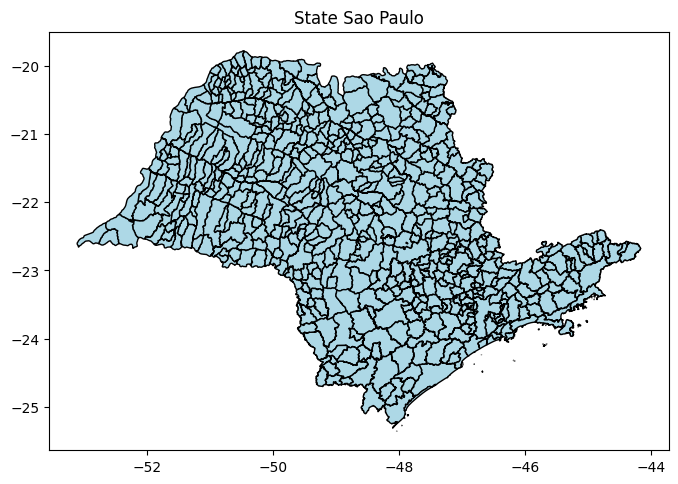

In [15]:
gdf_sp = read_municipality(code_muni="SP", year=2021)
codes_sp = gdf_sp['code_muni'].astype(int).astype(str).tolist()
# Plot
gdf_sp.plot(figsize=(8, 8), edgecolor="black", facecolor="lightblue")
plt.title("State Sao Paulo")
plt.show()

In [16]:
downdload_data = False # Manual switch to download data
if downdload_data == True:
  all_data = []
  y_start= 2021
  y_end = 2025
  for geocode in tqdm(codes_sp, desc="Downloading"):
      try:
          df = data_donwload(geocode, y_start=y_start, y_end=y_end)
          df['ibge'] = geocode
          all_data.append(df)
      except Exception as e:
          print(f"Failed for {geocode}: {e}")
      time.sleep(0.1)

  data_sp = pd.concat(all_data)
  data_sp.head()

  del all_data
  gc.collect()

  # Save in my drive so i don't need to redownload
  data_sp2 = data_sp[['data_iniSE', 'ibge', 'nivel', 'casos', 'umidmed', 'tempmed', 'pop']]
  save_path = "/content/drive/MyDrive/GISAID/data_sp_incidence.csv"
  data_sp2.to_csv(save_path, index=False)
  print(f"File saved to: {save_path}")

else:
  data_sp2 = pd.read_csv('/content/drive/MyDrive/GISAID/data_sp_incidence.csv')

data_sp2.head(5)

,data_iniSE,ibge,nivel,casos,umidmed,tempmed,pop
0,2025-09-07,3500105,1,15,41.283775,26.103950,34357.0
1,2025-08-31,3500105,1,22,40.892229,25.794371,34357.0
2,2025-08-24,3500105,1,10,56.847486,22.895343,34357.0
3,2025-08-17,3500105,1,12,41.691471,25.340443,34357.0
4,2025-08-10,3500105,1,7,45.644986,17.593957,34357.0


In [17]:
summary = data_sp2.groupby('data_iniSE').agg({"casos": "sum",
                                              "tempmed": "mean",
                                              "umidmed": "mean",
                                              "pop" : "sum"
                                        }).reset_index()

summary = summary[summary['data_iniSE'] <= '2025-07-01']
summary['data_iniSE'] = pd.to_datetime(summary['data_iniSE'])
summary['casos_100k'] = summary['casos'] / summary['pop'] * 100000
summary

,data_iniSE,casos,tempmed,umidmed,pop,casos_100k
0,2021-01-03,3784,25.482833,69.558708,46289333.0,8.174670
1,2021-01-10,3968,24.934893,77.908664,46289333.0,8.572169
2,2021-01-17,4811,25.741954,69.843846,46289333.0,10.393323
3,2021-01-24,5531,25.518964,69.127408,46289333.0,11.948757
4,2021-01-31,7201,25.356603,71.282783,46289333.0,15.556500
...,...,...,...,...,...,...
230,2025-06-01,28748,19.786709,76.270582,46024937.0,62.461791
231,2025-06-08,19848,16.823854,75.386224,46024937.0,43.124448
232,2025-06-15,15510,19.075310,66.537811,46024937.0,33.699123
233,2025-06-22,12727,18.019178,69.653567,46024937.0,27.652401


In [18]:
summary.isna().sum()

,0
data_iniSE,0
casos,0
tempmed,0
umidmed,0
pop,0
casos_100k,0


# Sao Paolo Data Cleaning and Adjustment

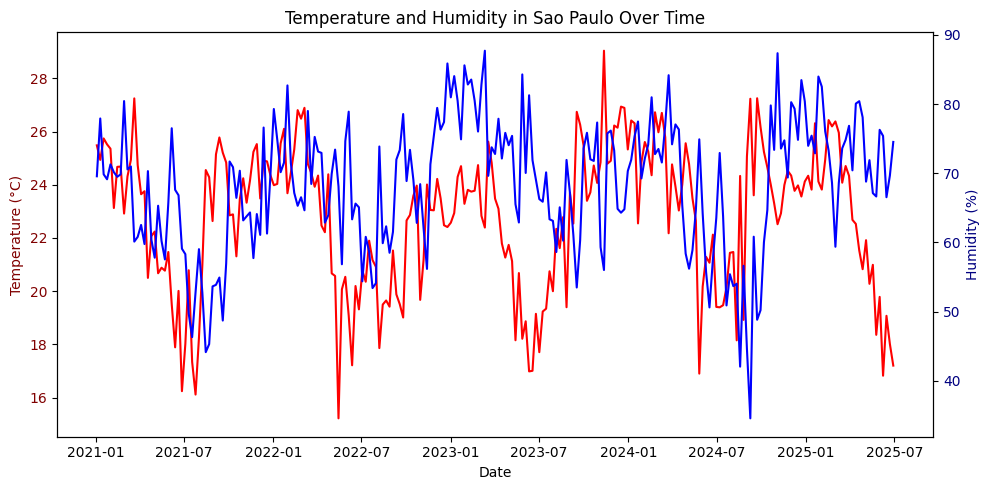

In [19]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(summary['data_iniSE'], summary['tempmed'], color='red', label='Temp (°C)')
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°C)", color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')

ax2 = ax1.twinx()
ax2.plot(summary['data_iniSE'], summary['umidmed'], color='blue', label='Humidity (%)')
ax2.set_ylabel("Humidity (%)", color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

plt.title("Temperature and Humidity in Sao Paulo Over Time")

fig.tight_layout()
plt.show()

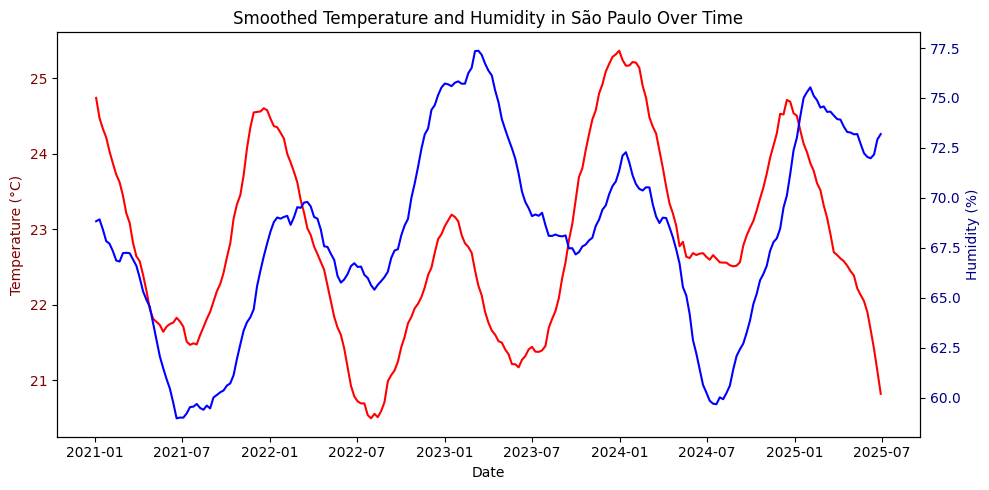

In [20]:
df_smooth = summary.copy()
df_smooth["tempmed_smooth"] = df_smooth["tempmed"].rolling(window=30, center=True, min_periods=1).mean()
df_smooth["umidmed_smooth"] = df_smooth["umidmed"].rolling(window=30, center=True, min_periods=1).mean()
df_smooth["casos_smooth"] = df_smooth["casos"].rolling(window=30, center=True, min_periods=1).mean()
df_smooth["casos_100k_smooth"] = df_smooth["casos_100k"].rolling(window=30, center=True, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(df_smooth['data_iniSE'], df_smooth['tempmed_smooth'],
         color='red', label='Temp (°C, smoothed)')
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°C)", color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')

ax2 = ax1.twinx()
ax2.plot(df_smooth['data_iniSE'], df_smooth['umidmed_smooth'],
         color='blue', label='Humidity (% , smoothed)')
ax2.set_ylabel("Humidity (%)", color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

plt.title("Smoothed Temperature and Humidity in São Paulo Over Time")
fig.tight_layout()
plt.show()


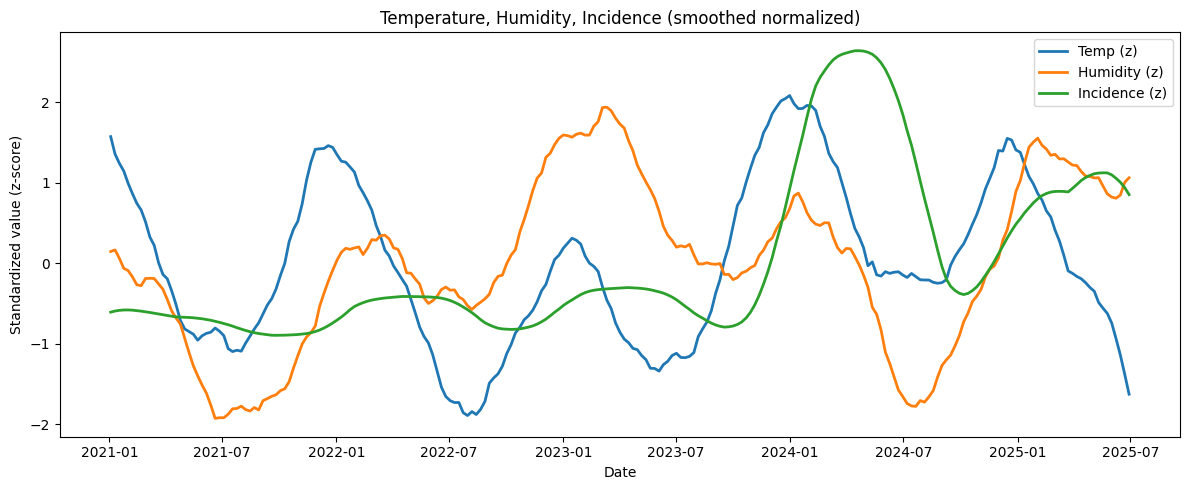

In [71]:
# smooth first (you already had this)
df_smooth = summary.copy()
df_smooth["tempmed_smooth"] = df_smooth["tempmed"].rolling(30, center=True, min_periods=1).mean()
df_smooth["umidmed_smooth"] = df_smooth["umidmed"].rolling(30, center=True, min_periods=1).mean()
df_smooth["casos_smooth"] = df_smooth["casos"].rolling(30, center=True, min_periods=1).mean()

# standardize to the same scale (z-scores)
for c in ["tempmed_smooth", "umidmed_smooth", "casos_smooth"]:
    mu = df_smooth[c].mean()
    sd = df_smooth[c].std()
    df_smooth[c + "_z"] = (df_smooth[c] - mu) / sd

# single-axis plot (same scale)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_smooth["data_iniSE"], df_smooth["tempmed_smooth_z"], label="Temp (z)", linewidth=2)
plt.plot(df_smooth["data_iniSE"], df_smooth["umidmed_smooth_z"], label="Humidity (z)", linewidth=2)
plt.plot(df_smooth["data_iniSE"], df_smooth["casos_smooth_z"], label="Incidence (z)", linewidth=2)

plt.title("Temperature, Humidity, Incidence (smoothed normalized)")
plt.xlabel("Date")
plt.ylabel("Standardized value (z-score)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
  def plot_int(df_gen, df_casos, region):

    df_gen = df_gen.sort_values('time')
    df_casos = df_casos.sort_values('data_iniSE')

    # PLot serotype
    fig = px.area(
        df_gen,
        x='time', y='percent', color='var',
        labels={'time':'Date', 'percent':'Proportion', 'var':'Serotype'},
        title=f'Serotype Progression and Dengue Incidence in {region}'
    )

    fig.update_traces(mode='lines+markers', connectgaps=False)

    fig.add_trace(
        go.Scatter(
            x=df_casos['data_iniSE'],
            y=df_casos['casos_100k'],
            name="Incidence",
            mode="lines+markers",
            line=dict(color="black"),
            yaxis="y2"
        )
    )

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y",
    #     rangeslider_visible=True,
    #     rangeslider=dict(bgcolor='grey')
    # )

    fig.update_layout(
        yaxis=dict(title="Proportion", tickformat=".0%", range=[0, 1]),
        yaxis2=dict(title="Incidence per 100k pop", overlaying="y", side="right"),
        xaxis=dict(range=[df_gen['time'].min(), df_gen['time'].max()]),
        legend_title_text=''
    )

    fig.show()


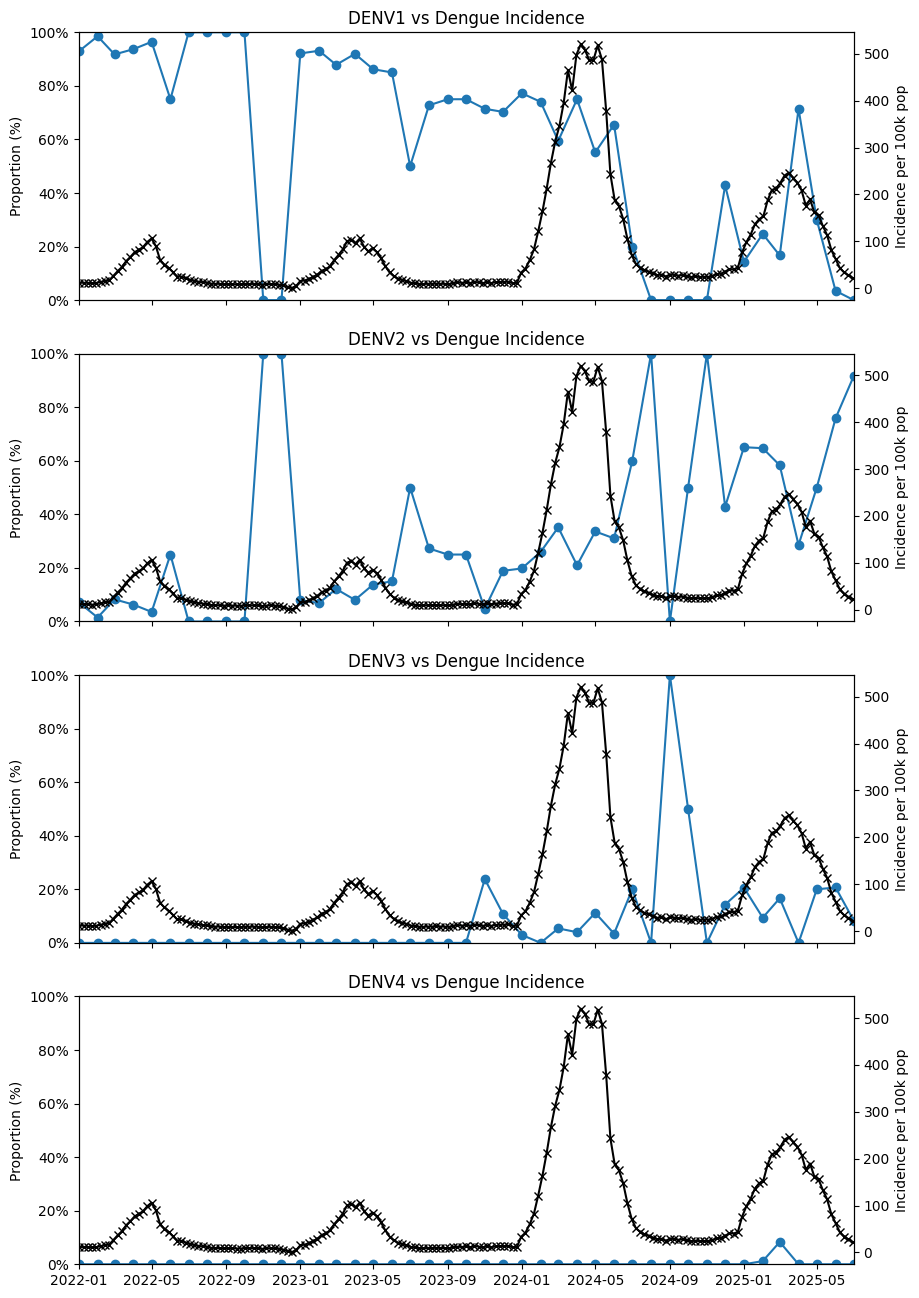

In [22]:
df_gen = sero_df1
df_casos = summary

start = (df_gen["time"].min())
end = (df_gen["time"].max())

df_gen['percent'] = df_gen['percent'].astype(float)
vvar = df_gen['var'].unique()
n = len(vvar)

fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), sharex=True)
if n == 1:
    axes = [axes]

for i, vv in enumerate(vvar):

  ax = axes[i]
  sub = df_gen[df_gen['var'] == vv]

  ax.plot(sub['time'], sub['percent'], marker='o', label=f"{vv}", color="tab:blue")
  ax.set_ylabel("Proportion (%)")
  ax.set_ylim(0, 1)
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

  ax2 = ax.twinx()
  ax2.plot(df_casos['data_iniSE'], df_casos['casos_100k'], marker='x', color="black", label="Incidence per 100k pop")
  ax2.set_ylabel('Incidence per 100k pop')

  ax.set_title(f"{vv} vs Dengue Incidence")
  ax.set_xlim(start, end)


In [36]:
plot_int(df_gen=sero_df1, df_casos=summary ,region='Sao Paulo')

the past 12 weeks of temperature correlates the strongest with the incidence
the past 18 weeks of humidities correlates the strongest with the incidence


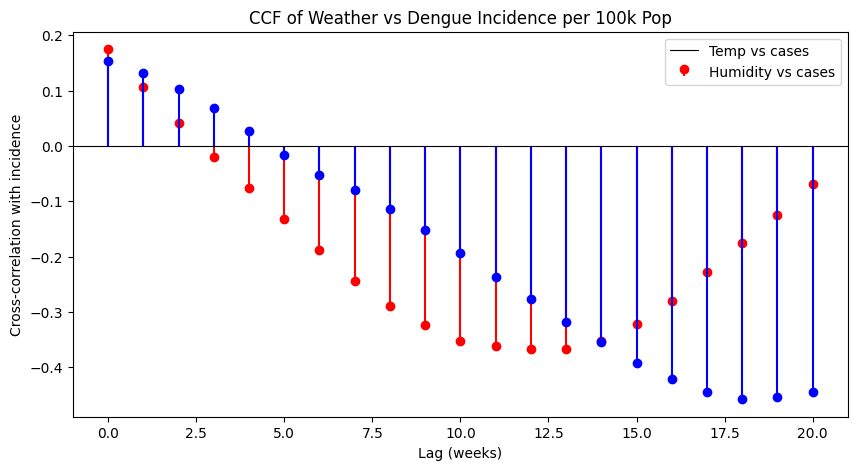

In [37]:
# Adjust the weather data based on the lag
df_ccf = summary.dropna(subset=["casos_100k","tempmed","umidmed"]).copy()

# Normalize
for c in ["casos","tempmed","umidmed"]:
    df_ccf[c+"_z"] = (df_ccf[c] - df_ccf[c].mean()) / df_ccf[c].std()

# CCF calculation
max_lag = 20
ccf_temp = ccf(df_ccf["tempmed_z"], df_ccf["casos_z"])[:max_lag+1]
ccf_humid = ccf(df_ccf["umidmed_z"], df_ccf["casos_z"])[:max_lag+1]

lags = np.arange(0, max_lag+1)
best_lag_temp = lags[np.argmax(abs(ccf_temp))]
best_lag_humid = lags[np.argmax(abs(ccf_humid))]
print(f"the past {best_lag_temp} weeks of temperature correlates the strongest with the incidence")
print(f"the past {best_lag_humid} weeks of humidities correlates the strongest with the incidence")

lags = np.arange(0, max_lag+1)
plt.figure(figsize=(10,5))
plt.stem(lags, ccf_temp, linefmt="r-", markerfmt="ro", basefmt=" ")
plt.stem(lags, ccf_humid, linefmt="b-", markerfmt="bo", basefmt=" ")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Lag (weeks)")
plt.ylabel("Cross-correlation with incidence")
plt.title("CCF of Weather vs Dengue Incidence per 100k Pop")
plt.legend(["Temp vs cases","Humidity vs cases"])
plt.show()

In [38]:
sum2 = summary.copy()

sum2["temp_lag"] = sum2["tempmed"].shift(best_lag_temp)
sum2["hum_lag"]  = sum2["umidmed"].shift(best_lag_humid)
sum2 = sum2[sum2["data_iniSE"] >= "2022-01-01"].reset_index(drop=True)

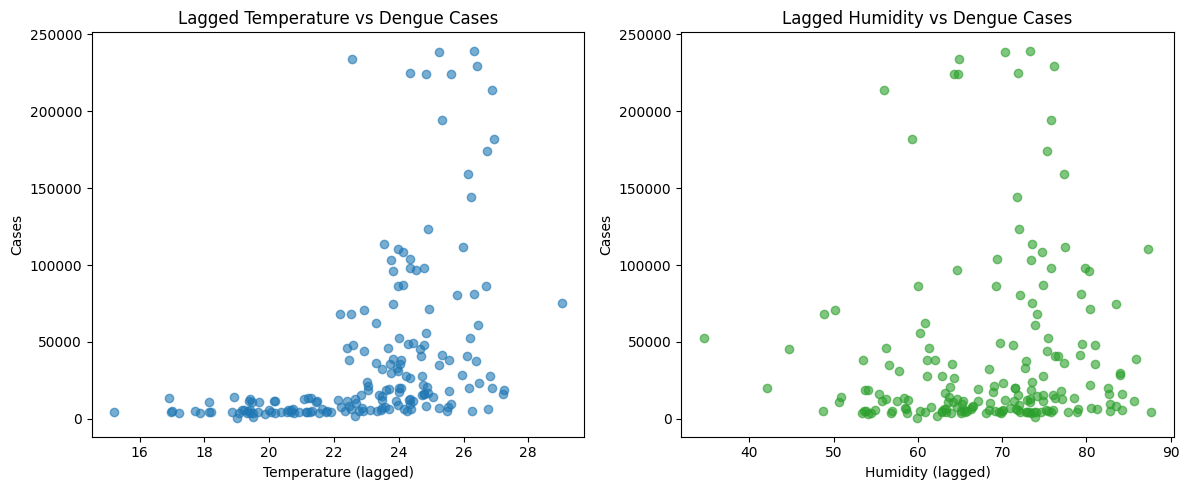

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# temp vs cases
axes[0].scatter(sum2["temp_lag"], sum2["casos"], alpha=0.6, color="tab:blue")
axes[0].set_xlabel("Temperature (lagged)")
axes[0].set_ylabel("Cases")
axes[0].set_title("Lagged Temperature vs Dengue Cases")

# humidity vs cases
axes[1].scatter(sum2["hum_lag"], sum2["casos"], alpha=0.6, color="tab:green")
axes[1].set_xlabel("Humidity (lagged)")
axes[1].set_ylabel("Cases")
axes[1].set_title("Lagged Humidity vs Dengue Cases")

plt.tight_layout()
plt.show()

In [40]:
# Manually interpolate the odd periods
# oct 2022 - jan 2023 hole and 2024

mask1 = ((sero_df1['time'] >= '2022-10-01') &
        (sero_df1['time'] <= '2023-01-01') &
        (sero_df1['var'] == 'DENV1'))

s = sero_df1.loc[mask1, 'percent'].copy()
s[s == 0] = np.nan
s_interp = s.interpolate(method="linear")

sero_df1_interp = sero_df1.copy()
sero_df1_interp.loc[mask1, 'percent'] = s_interp


mask2 = ((sero_df1['time'] > '2022-10-01') &
        (sero_df1['time'] < '2023-01-01') &
        (sero_df1['var'] == 'DENV2'))

sero_df1_interp.loc[mask2, 'percent'] = 1-s_interp


mask3 = ((sero_df1['time'] >= '2024-07-01') &
        (sero_df1['time'] <= '2024-10-01') &
        (sero_df1['var'] == 'DENV2'))

s = sero_df1.loc[mask3]['percent'].copy()

s.iloc[1:3] = np.nan
s_interp = s.interpolate(method="linear")

sero_df1_interp.loc[mask3, 'percent'] = s_interp


mask4 = ((sero_df1['time'] >= '2024-07-01') &
        (sero_df1['time'] <= '2024-10-01') &
        (sero_df1['var'] == 'DENV3'))

s2 = sero_df1.loc[mask4]['percent'].copy()

s2.iloc[1:3] = np.nan
s_interp2 = s2.interpolate(method="linear")

sero_df1_interp.loc[mask4, 'percent'] = s_interp2

mask5 = ((sero_df1['time'] > '2024-07-01') &
        (sero_df1['time'] < '2024-10-01') &
        (sero_df1['var'] == 'DENV1'))

s3 = sero_df1.loc[mask5]['percent'].copy()
sero_df1_interp.loc[mask5, 'percent'] = 1-s_interp-s_interp2

mask6 = ((sero_df1['time'] >= '2024-10-01') &
        (sero_df1['time'] <= '2024-12-01') &
        (sero_df1['var'] == 'DENV3'))

s4 = sero_df1.loc[mask6]['percent'].copy()
s4[s4 == 0] = np.nan
s_interp3 = s4.interpolate(method="linear")
sero_df1_interp.loc[mask6, 'percent'] = s_interp3

mask7 = ((sero_df1['time'] > '2024-10-01') &
        (sero_df1['time'] < '2024-12-01') &
        (sero_df1['var'] == 'DENV2'))

s4 = sero_df1.loc[mask7]['percent'].copy()
sero_df1_interp.loc[mask7, 'percent'] = 1-s_interp3

In [41]:
plot_int(df_gen=sero_df1_interp, df_casos=summary ,region='Sao Paulo')

## Prototype 1:
- Only Sao Paulo (as a first testing subject)
- Check the lags on the weather data and adjust the temperature and humidity based on the average on the past lags
- Manually impute data on the serotype (for experiment)

- Make the monthly serotype data into weekly data via carry forward

- Make 1 GLM model only weather
- Make 1 GLM model only serotype (use the ILR (isometric log-ratio) value)
- Make 1 GLM model weather + serotype (use the ILR (isometric log-ratio) value)

- Then compare AIC

Extra note:
- I am not convinced in the interpolation steps
- I am not sure if my analysis is correct and the results can actually points to anything of substance even when the data cleaning is already correct
---



In [49]:
# Still need to account for rounding errors
sum2["year"] = sum2["data_iniSE"].dt.year
sum2["month"] = sum2["data_iniSE"].dt.month

sero_wide = (sero_df1_interp
             .pivot(index="time", columns="var", values="percent")
             .reset_index())

sero = list(sero_df1['var'].unique())

sero_wide["year"] = sero_wide["time"].dt.year
sero_wide["month"] = sero_wide["time"].dt.month

comb1 = sum2.merge(sero_wide[["year","month"]+sero],  on=["year","month"], how="left")

# While it is really suggested to normalize, i try anyway
cols_to_scale = ["temp_lag", "hum_lag"]
scaler = StandardScaler()
comb1_norm = comb1.copy()
comb1_norm[cols_to_scale] = scaler.fit_transform(comb1_norm[cols_to_scale])

In [50]:
def run_glm (formula_ver):
  # manual gridsearch alpha
  alphas = [0.1, 0.3, 0.5, 0.65, 0.8, 1.0, 2.0]
  best = None

  for a in alphas:
      mod2 = smf.glm(
          formula=formula_ver,
          data=comb1_norm,
          family=sm.families.NegativeBinomial(alpha=a)
      )
      res = mod2.fit()

      # compute AICc (AIC + small-sample correction)
      k = res.df_model + 1
      n = res.nobs

      if n <= k + 1: # in the case of the model being too complex
          print(f"AICc undefined for alpha={a:.3f} "
                f"(n={n}, k={k}). Model may be too complex.")
          aicc = np.inf
      else:
          aicc = res.aic + (2*k*(k+1)) / (n - k - 1)

      if (best is None) or (aicc < best[0]):
          best = (aicc, a, res)

      aicc = res.aic + (2*k*(k+1)) / max(n-k-1, 1)

      if (best is None) or (aicc < best[0]):
          best = (aicc, a, res)


  best_aicc2, best_alpha2, best_res2 = best
  print(f"Best α: {best_alpha2:.3f}, AICc: {best_aicc2:.2f}, LogLik: {best_res2.llf:.2f}\n")
  print(best_res2.summary())

  return  best

### GLM 1 : Weather only

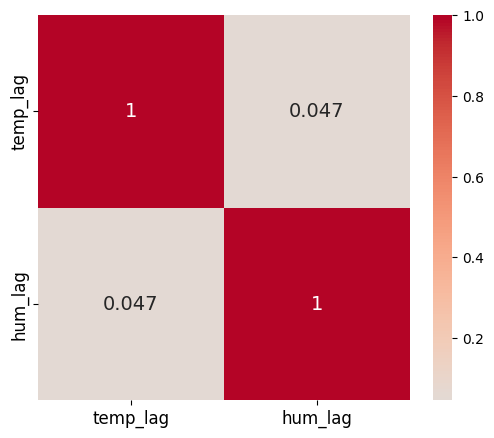

In [51]:
## Check correlation between temperature and humidities
plt.figure(figsize=(6,5))
sns.heatmap(
    (comb1_norm[["temp_lag","hum_lag"]].corr(method="pearson")),
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size":14}
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [84]:
# GLM only weather
formula2 = """
casos_100k ~ bs(temp_lag, df=3) + bs(hum_lag, df=3)
"""

best_aicc2, best_alpha2, best_res2 = run_glm(formula2)

Best α: 0.800, AICc: 1875.67, LogLik: -930.52

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      176
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -930.52
Date:                Mon, 22 Sep 2025   Deviance:                       197.47
Time:                        00:19:02   Pearson chi2:                     265.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5752
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

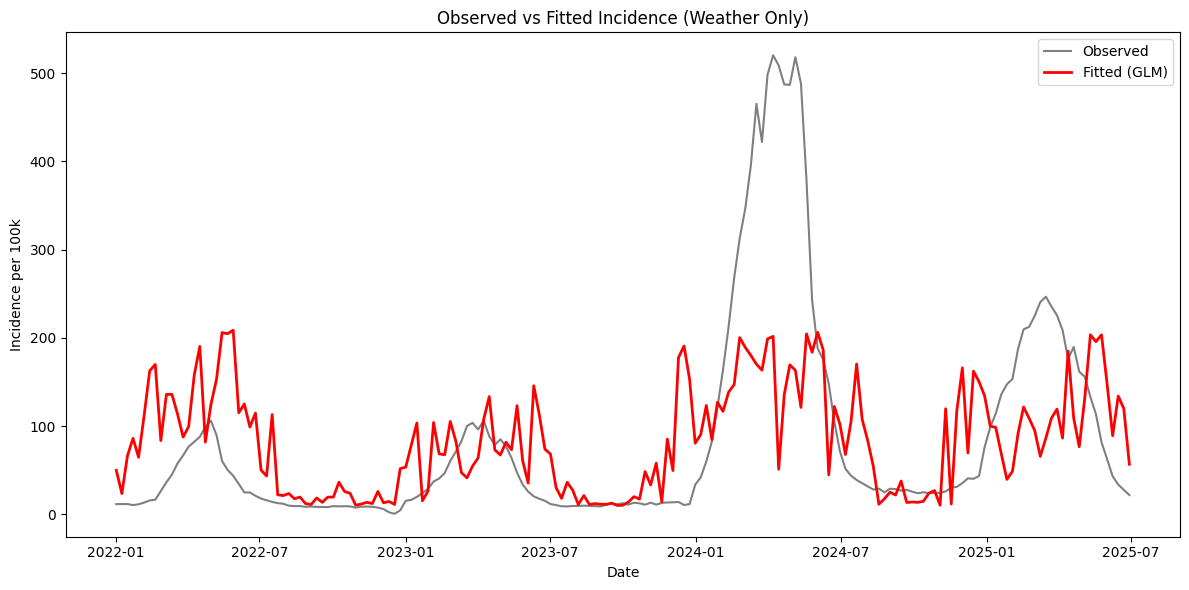

In [85]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(comb1_norm["data_iniSE"], comb1_norm["casos_100k"],
        label="Observed", color="black", alpha=0.5)

ax.plot(comb1_norm["data_iniSE"], best_res2.fittedvalues,
        label="Fitted (GLM)", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Incidence per 100k")
ax.set_title("Observed vs Fitted Incidence (Weather Only)")
ax.legend()
plt.tight_layout()
plt.show()

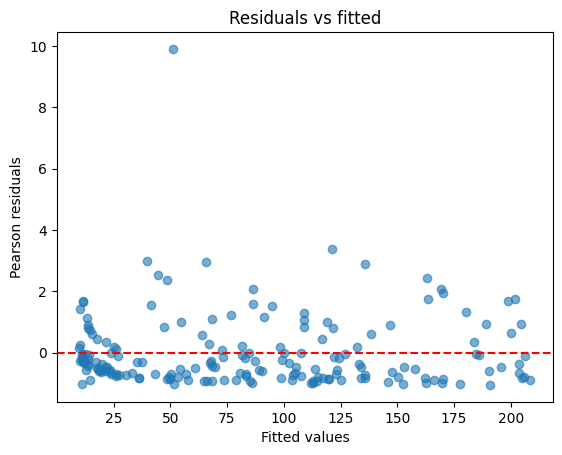

In [86]:
plt.scatter(best_res2.fittedvalues, best_res2.resid_pearson, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs fitted")
plt.show()

### GLM 2 :  Serotype Competition

With only the proportion

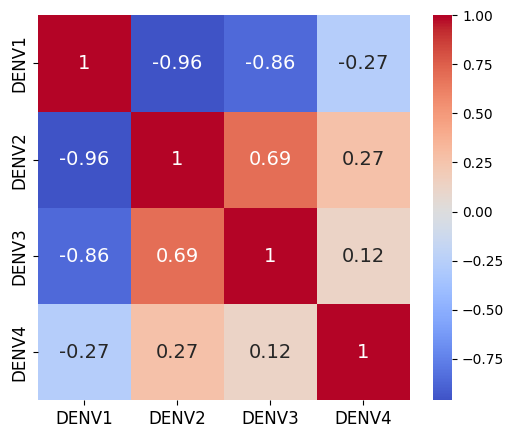

In [55]:
## Check correlation between temperature and humidities
plt.figure(figsize=(6,5))
sns.heatmap(
    (comb1_norm[["DENV1", "DENV2", "DENV3", "DENV4" ]].corr(method="pearson")),
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size":14}
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [94]:
# GLM simplest form
formula2a = """
casos_100k  ~ bs(DENV1, df=3) + bs(DENV4, df=3)
"""

best_aicc2a, best_alpha2a, best_res2a = run_glm(formula2a)

Best α: 0.800, AICc: 1897.93, LogLik: -942.72

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      177
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -942.72
Date:                Mon, 22 Sep 2025   Deviance:                       221.88
Time:                        00:22:05   Pearson chi2:                     188.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5146
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

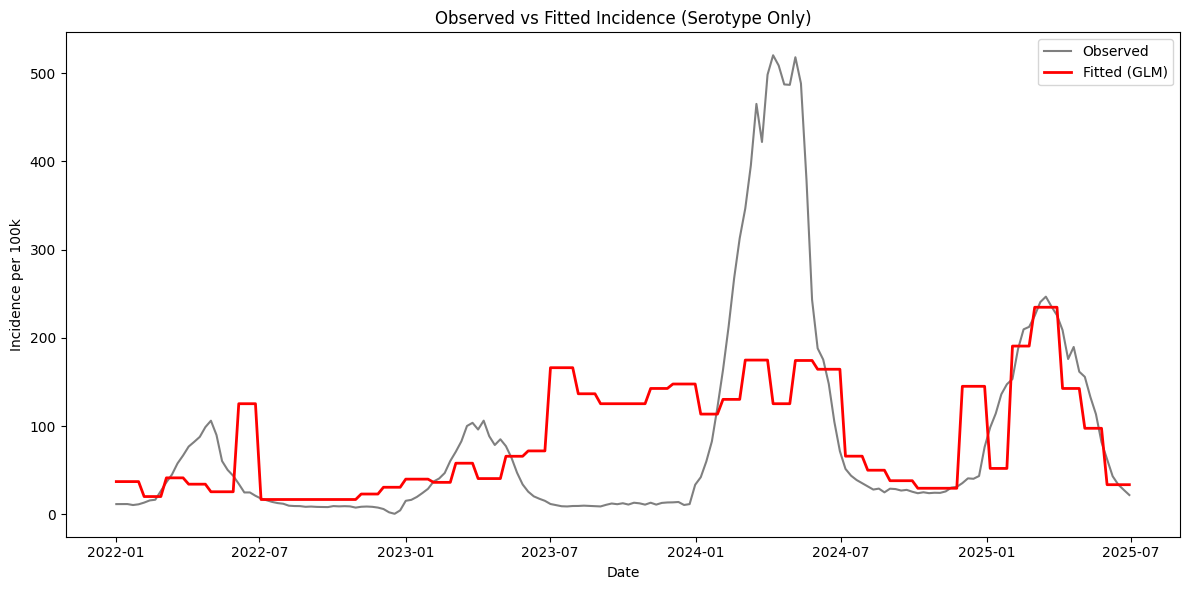

In [95]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(comb1_norm["data_iniSE"], comb1_norm["casos_100k"],
        label="Observed", color="black", alpha=0.5)

ax.plot(comb1_norm["data_iniSE"], best_res2a.fittedvalues,
        label="Fitted (GLM)", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Incidence per 100k")
ax.set_title("Observed vs Fitted Incidence (Serotype Only)")
ax.legend()
plt.tight_layout()
plt.show()

**ILR (Isometric Log-Ratio) balances for serotype competition**

Let \(p_1, p_2, p_3, p_4\) be the proportions of DENV1–DENV4 (each time step, sum to 1).

- **DENV2 vs DENV1**

$$
b_2 = \sqrt{\tfrac{1}{2}} \log\left(\frac{p_2}{p_1}\right)
$$

- **DENV3 vs \{DENV1, DENV2\}**

$$
b_3 = \sqrt{\tfrac{2}{3}} \; \log\!\left(\frac{p_3}{\sqrt{p_1 \, p_2}}\right)
$$

- **DENV4 vs \{DENV1, DENV2, DENV3\}**

$$
b_4 = \sqrt{\tfrac{3}{4}} \; \log\!\left(\frac{p_4}{(p_1 p_2 p_3)^{1/3}}\right)
$$


In [58]:
P = comb1_norm[sero].div(comb1_norm[sero].sum(axis=1), axis=0).clip(1e-6, 1-1e-6)

b2 = np.sqrt(1/2) * np.log(P["DENV2"] / P["DENV1"])
b3 = np.sqrt(2/3) * np.log(P["DENV3"] / np.sqrt(P["DENV1"]*P["DENV2"]))
b4 = np.sqrt(3/4) * np.log(P["DENV4"] / (P["DENV1"]*P["DENV2"]*P["DENV3"])**(1/3))

b2a = np.sqrt(1/2) * np.log(P["DENV3"] / P["DENV2"])

comb1_norm["ILR_2v1"] = b2
comb1_norm["ILR_3v2"] = b2a
comb1_norm["ILR_3v12"] = b3
comb1_norm["ILR_4v123"] = b4

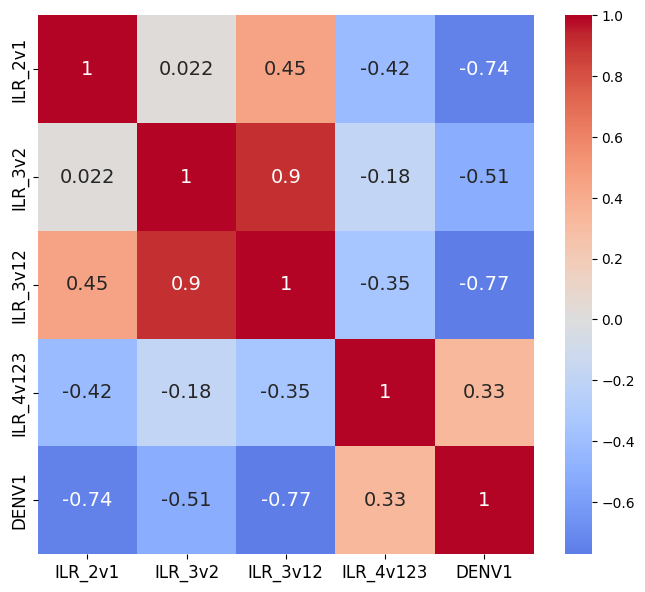

In [59]:
## Check correlation between temperature and humidities
plt.figure(figsize=(8,7))
sns.heatmap(
    (comb1_norm[["ILR_2v1", "ILR_3v2", "ILR_3v12", "ILR_4v123", "DENV1" ]].corr(method="pearson")),
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size":14}
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [77]:
formula3 = """
casos_100k ~  ILR_2v1 + ILR_3v12 + ILR_4v123
"""

best_aicc3, best_alpha3, best_res3 = run_glm(formula3)

Best α: 1.000, AICc: 1961.28, LogLik: -976.53

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      179
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -976.53
Date:                Mon, 22 Sep 2025   Deviance:                       245.07
Time:                        00:17:27   Pearson chi2:                     253.
No. Iterations:                    24   Pseudo R-squ. (CS):             0.1960
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

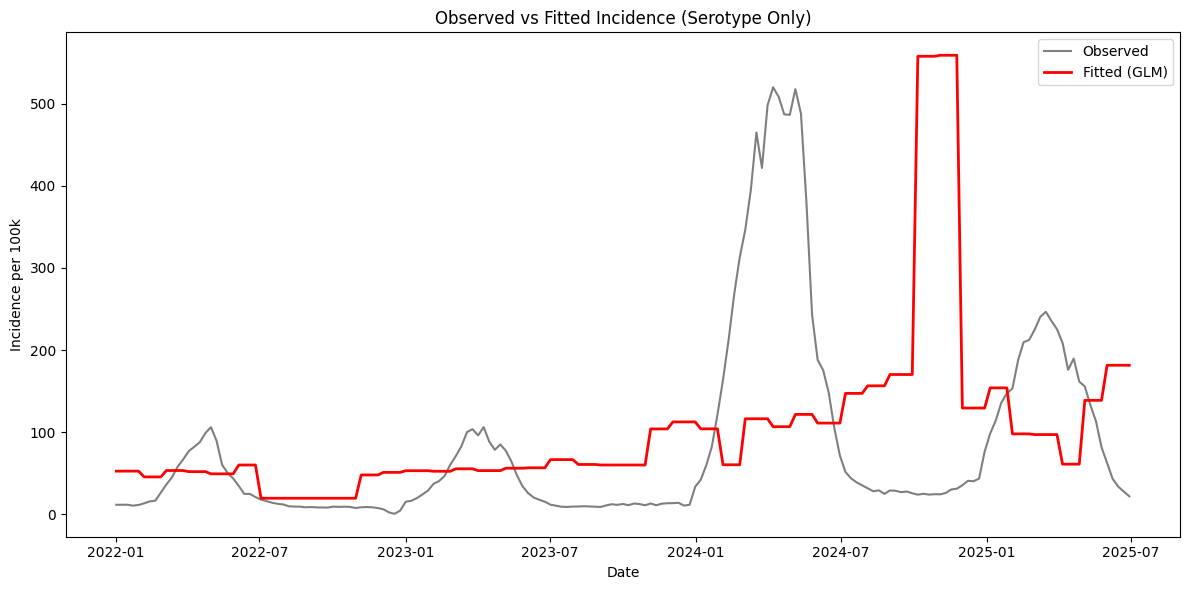

In [81]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(comb1_norm["data_iniSE"], comb1_norm["casos_100k"],
        label="Observed", color="black", alpha=0.5)

ax.plot(comb1_norm["data_iniSE"], best_res3.fittedvalues,
        label="Fitted (GLM)", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Incidence per 100k")
ax.set_title("Observed vs Fitted Incidence (Serotype Only)")
ax.legend()
plt.tight_layout()
plt.show()

In [78]:
formula3s = """
casos_100k ~  bs(ILR_2v1, df=3) + bs(ILR_3v12, df=3) + bs(ILR_4v123, df=3)
"""

best_aicc3s, best_alpha3s, best_res3s = run_glm(formula3s)

Best α: 0.800, AICc: 1873.14, LogLik: -925.93

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      173
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -925.93
Date:                Mon, 22 Sep 2025   Deviance:                       188.29
Time:                        00:17:31   Pearson chi2:                     200.
No. Iterations:                    17   Pseudo R-squ. (CS):             0.5960
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

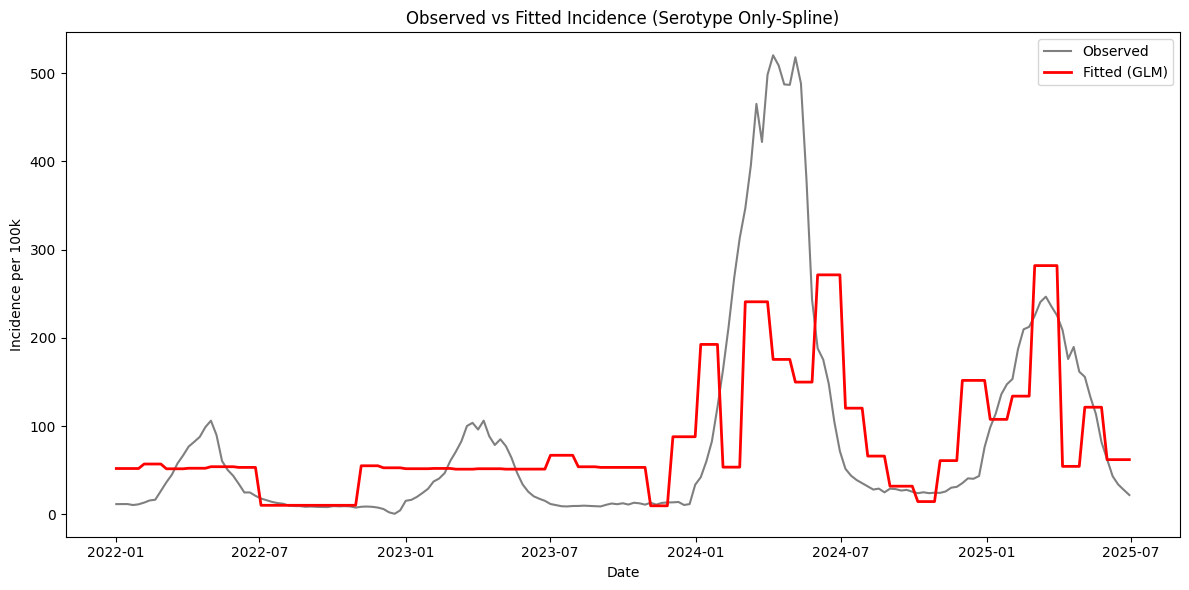

In [80]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(comb1_norm["data_iniSE"], comb1_norm["casos_100k"],
        label="Observed", color="black", alpha=0.5)

ax.plot(comb1_norm["data_iniSE"], best_res3s.fittedvalues,
        label="Fitted (GLM)", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Incidence per 100k")
ax.set_title("Observed vs Fitted Incidence (Serotype Only-Spline)")
ax.legend()
plt.tight_layout()
plt.show()

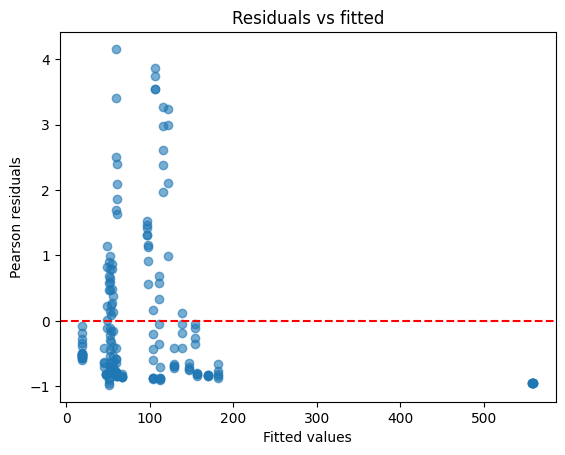

In [82]:
plt.scatter(best_res3.fittedvalues, best_res3.resid_pearson, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs fitted")
plt.show()

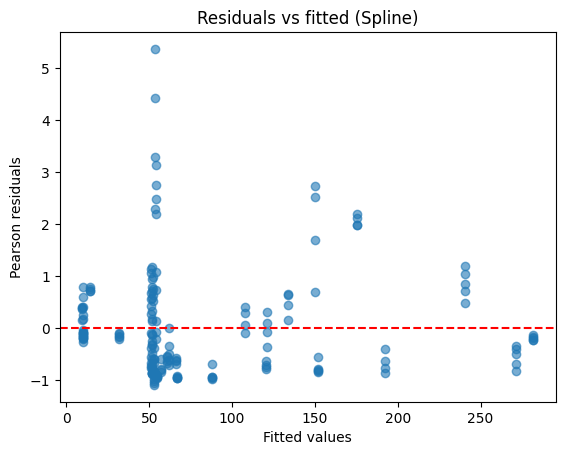

In [83]:
plt.scatter(best_res3s.fittedvalues, best_res3s.resid_pearson, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs fitted (Spline)")
plt.show()

### GLM 3 : Weather + Serotype Competition

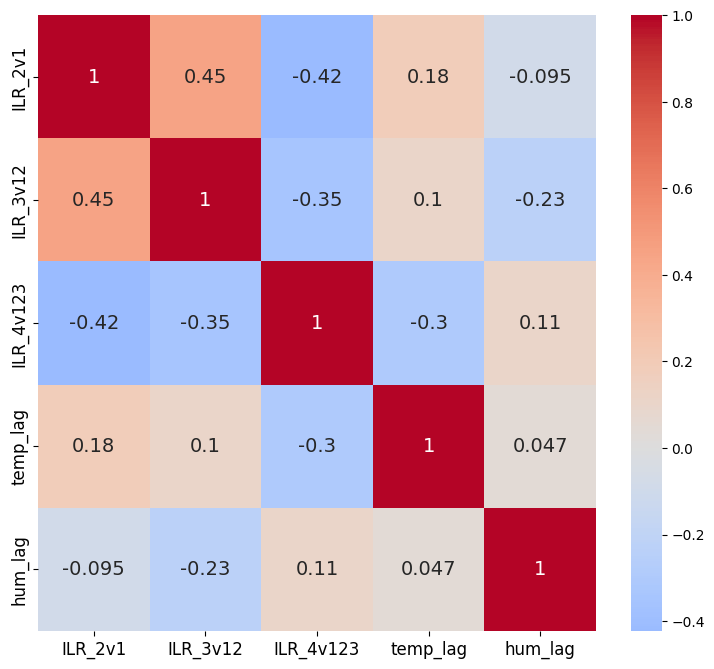

In [87]:
## Check correlation between temperature and humidities
plt.figure(figsize=(9,8))
sns.heatmap(
    (comb1_norm[["ILR_2v1", "ILR_3v12", "ILR_4v123", "temp_lag","hum_lag"]].corr(method="pearson")),
    annot=True,
    cmap="coolwarm",
    center=0,
    annot_kws={"size":14}
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [91]:
formula4 = """
 casos_100k ~   bs(ILR_2v1, df=3) + bs(ILR_3v12, df=3) + bs(ILR_4v123, df=3) + bs(temp_lag, df=3) + bs(hum_lag, df=3)
"""

#  casos_100k ~  ILR_2v1 + ILR_3v12 + ILR_4v123  + bs(temp_lag, df=3) + bs(hum_lag, df=3) + C(year)


best_aicc4, best_alpha4, best_res4 = run_glm(formula4)

Best α: 0.500, AICc: 1823.96, LogLik: -894.34

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      167
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -894.34
Date:                Mon, 22 Sep 2025   Deviance:                       213.88
Time:                        00:20:04   Pearson chi2:                     226.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.8467
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

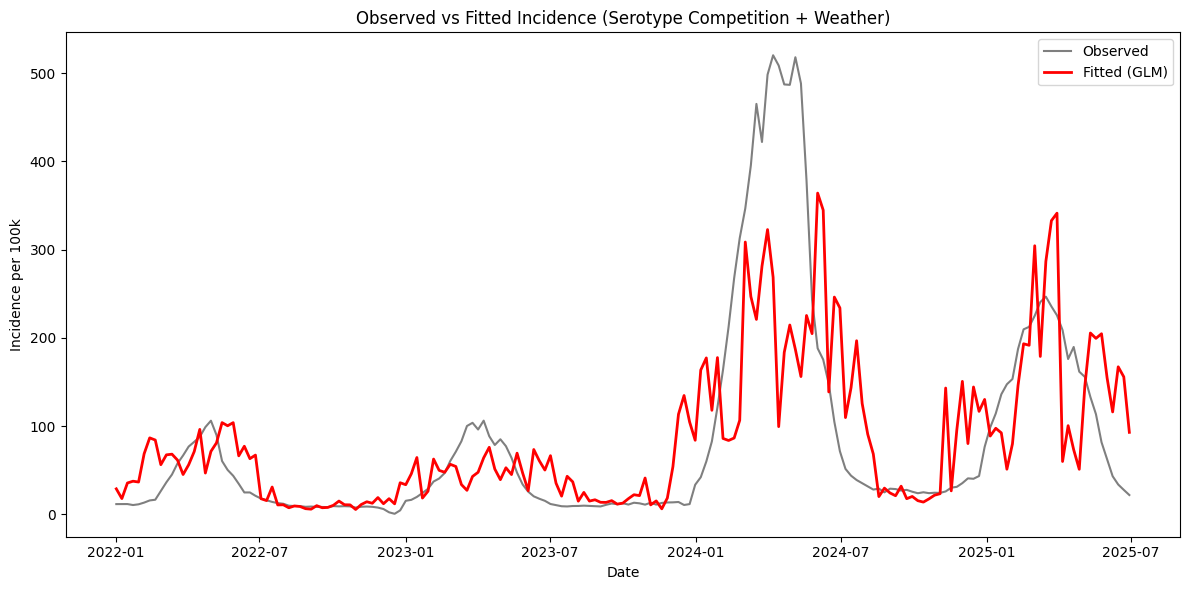

In [92]:
comb1_norm = comb1_norm.copy()
comb1_norm["fitted_weather_sero"] = best_res4.fittedvalues

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(comb1_norm["data_iniSE"], comb1_norm["casos_100k"],
        label="Observed", color="black", alpha=0.5)

ax.plot(comb1_norm["data_iniSE"], comb1_norm["fitted_weather_sero"],
        label="Fitted (GLM)", color="red", linewidth=2)

ax.set_xlabel("Date")
ax.set_ylabel("Incidence per 100k")
ax.set_title("Observed vs Fitted Incidence (Serotype Competition + Weather)")
ax.legend()
plt.tight_layout()
plt.show()

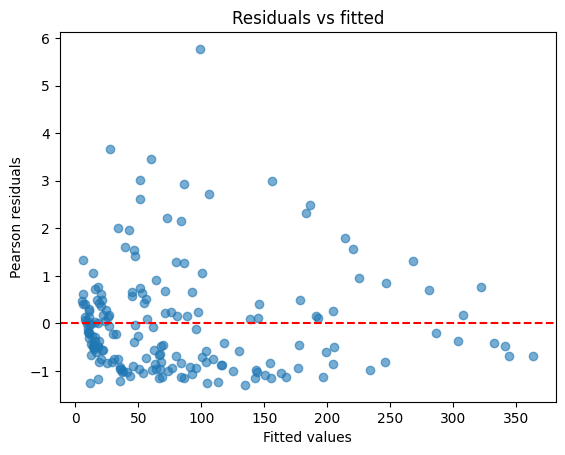

In [93]:
plt.scatter(best_res4.fittedvalues, best_res4.resid_pearson, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs fitted")
plt.show()